# Game flow chart

The purpose of this module is to show an example of how to build a chart that displays a simple gameflow chart.

Game flow charts give a general indication of which team is having a dominant spell of possession and is typically 
represented by a series of bars corresponding to each section of the game.  Each team has its own set of bars.

The higher the bars for a given team the more dominant the team was during that spell of the game

In this example, you will see how to take simple event data, transform it into a pandas DataFrame representing
game flow and then how to create a matplotlib chart to display the data.

## Data Loading

We will load an example of match event data from a csv file.  The file has the following format
```
,team,is_goal,x,y
0,chelsea,0,50.0,50.0
1,chelsea,0,34.8,26.6
2,chelsea,0,71.8,2.0
3,wolves,0,29.1,89.1
```

Each row represents an event and contains the following data
- team: Which team executed this event
- period: Which half the event was during
- minute: which minute of the game the event has occured in
- is_goal: Whether the event was a goal or not (will be used for representing goals on the chart)
- x: the x coordinate of the event, from 0 to 100
- y: the y coordinate of the event from 0 to 100

First, lets load the data

In [1]:
import pandas as pd

data = pd.read_csv('../data/gameflow.csv', index_col=0)
data.head()

,team,period,minute,is_goal,x,y
0,crystal palace,1,0,0,50.0,50.0
1,crystal palace,1,0,0,32.1,64.0
3,chelsea,1,0,0,26.7,63.3
4,chelsea,1,0,0,25.9,84.6
5,crystal palace,1,0,0,55.0,32.5


# Data Processing

Next, we need to process the data. But before we do this, we need to agree on what we want our game flow chart to show.  Game flow charts usually some value that represents how "dangerous" a given spell of possession is. This can be done using a variety of advanced metrics, such as xThreat, Possession Value or On-Ball Value (https://statsbomb.com/soccer-metrics/possession-value-models-explained/). The easiest value to calculate is xThreat.  Specifically, we will be using the definition specified by John Muller and used on The Athletic's match dashboard (https://www.nytimes.com/athletic/5143083/2023/12/17/the-athletic-match-dashboard/) - the rolling 5 minute average of the maximum xThreat value over a given spell, capped at 0.20

### Compute xThreat

The easiest xThreat model to grab and use is the one defined by [Karun Singh](https://x.com/karun1710) in his original blog post (https://karun.in/blog/expected-threat.html).  The model divides the pitch into a 12x8 grid and assigns an xThreat value to each location.  Luckily Karun posted the link to his xThreat values online, so lets just grab them from there.

In [2]:
from typing import List
import requests
def get_xthreat_grid() -> List[List[float]]:
    """
    Retrieve the xthread grid from the web
    """

    r = requests.get("https://karun.in/blog/data/open_xt_12x8_v1.json")
    if r.status_code != 200:
        raise Exception("Could not retrieve xthreat grid")
    return r.json()

xthreat_grid = get_xthreat_grid()

Next, we need to process our data and assign each row a value from `xthreat_grid` based on the event's location on the pitch. The easiest way to do this is to split the `x` and `y` intervals into 12 and 8 bins respectively and use the bin index to look up the xThreat value.  We can do this using the pandas `cut` function. Please note that `fillna(0)` is needed because the `cut` function ignores the leftmost boundary, so any events with coordinate 0.0 will be `nan`



In [3]:
import pandas as pd
import numpy as np
def assign_xthreat_to_events(data:pd.DataFrame)->pd.DataFrame:
    """
    Assign xthreat values to each event in the data
    """
    xt_idx_x = pd.cut(data['x'], bins=np.linspace(0, 100, 13), labels=range(12)).fillna(0)
    xt_idx_y = pd.cut(data['y'], bins=np.linspace(0, 100, 9), labels=range(8)).fillna(0)
    data['xthreat'] = [xthreat_grid[y][x] for x, y in zip(xt_idx_x, xt_idx_y)]
    return data

data_2 = assign_xthreat_to_events(data.copy())
data_2.head()

,team,period,minute,is_goal,x,y,xthreat
0,crystal palace,1,0,0,50.0,50.0,0.014846
1,crystal palace,1,0,0,32.1,64.0,0.011105
3,chelsea,1,0,0,26.7,63.3,0.011105
4,chelsea,1,0,0,25.9,84.6,0.010595
5,crystal palace,1,0,0,55.0,32.5,0.016856


Now, lets group everything by period, minute and team and find the highest xThreat value each team had in a given minute of the game.  This is also where we will cap the xThreat at 0.20.

For simplicity sake, we should also fill in any minute for which a team did not record any possession events with 0

In [4]:
import pandas as pd
def bin_data_into_minutes(data:pd.DataFrame, max_xthreat_value:float)->pd.DataFrame:
    """
    Bin the data into periods, minutes and teams and cap at the maximum xthreat value
    """
    agg_data =  data.groupby(['period', 'minute', 'team']).agg({
        'xthreat': 'max',
        'is_goal': 'sum'
    }).reset_index().rename(columns={'is_goal': 'goals'})
    agg_data['xthreat'] = agg_data['xthreat'].clip(0, max_xthreat_value)
    return agg_data

def fill_missing_minutes(data:pd.DataFrame)->pd.DataFrame:
    """
    Fill in missing minutes in the data
    """
    max_minutes_in_period = data.groupby('period')['minute'].max().to_dict()
    
    periods = data['period'].unique()
    teams = data['team'].unique()
    full_data = []
    for period in periods:
        for minute in range(0, max_minutes_in_period[period]+1) if period == 1 else range(45, max_minutes_in_period[period]+1):
            for team in teams:
                if len(data[(data['period'] == period) & (data['minute'] == minute) & (data['team'] == team)]) == 0:
                    full_data.append({
                        'period': period,
                        'minute': minute,
                        'team': team,
                        'xthreat': 0,
                        'goals': 0
                    })
    full_data = pd.DataFrame(full_data)
    return pd.concat([data, full_data]).sort_values(['period', 'minute', 'team']).reset_index(drop=True)

data_3 = fill_missing_minutes(bin_data_into_minutes(data_2, 0.2))
data_3.head()

,period,minute,team,xthreat,goals
0,1,0,chelsea,0.014736,0
1,1,0,crystal palace,0.028552,0
2,1,1,chelsea,0.021221,0
3,1,1,crystal palace,0.000000,0
4,1,2,chelsea,0.054911,0


Finally, we want to smooth out the data to avoid spikes, so each bar on our gameflow chart will actually represent the weighted xThreat over the rolling last 5 minutes, so lets add a function for that as well.  In this case, as in John Muller's definition, we will use both leading and lagging 5 minute EWMA to compute an average run of play

In [5]:
import pandas as pd
def calculate_xthreat_ewma(data:pd.DataFrame, minute_rolling_window:float)->pd.DataFrame:
    """
    Calculate the exponentially weighted moving average of the xthreat values
    """

    def _compute_ewma(x:pd.Series, minute_rolling_window:float)->pd.Series:
        alpha = 2 / (minute_rolling_window + 1)
        lagging = x.ewm(alpha=alpha).mean().values
        leading = x.iloc[::-1].ewm(alpha=alpha).mean().iloc[::-1].values
        avg = np.concatenate([leading[:5], (leading[5:-5]+lagging[5:-5])/2, lagging[-5:]])
        
        return pd.Series(
            avg, index=x.index
        )
        

    
    data['xthreat'] = data.groupby(['team','period'])['xthreat'].transform(lambda x: _compute_ewma(x, minute_rolling_window))
    
    return data

data_4 = calculate_xthreat_ewma(data_3, 5)
data_4.tail()

,period,minute,team,xthreat,goals
201,2,96,crystal palace,0.021162,0
202,2,97,chelsea,0.030066,0
203,2,97,crystal palace,0.027665,0
204,2,98,chelsea,0.020044,0
205,2,98,crystal palace,0.054460,0


Now, lets put it altogether.  When working with pandas DataFrames and doing a series of data transformations, I find that grouping them all together using the `pipe` function produces very readable and modular code

In [6]:
processed_data = data.copy().pipe(
    assign_xthreat_to_events
).pipe(
    bin_data_into_minutes, max_xthreat_value=0.2
).pipe(
    fill_missing_minutes
).pipe(
    calculate_xthreat_ewma, minute_rolling_window=5
)
processed_data.tail()

,period,minute,team,xthreat,goals
201,2,96,crystal palace,0.021162,0
202,2,97,chelsea,0.030066,0
203,2,97,crystal palace,0.027665,0
204,2,98,chelsea,0.020044,0
205,2,98,crystal palace,0.054460,0


This concludes the data processing portion.  The next part is plotting the data using `matplotlib` to actually plot the data

## Data Plotting

In this section, we will be using `matplotlib`, my favourite python plotting library to actually create the gameflow visualisation.  This kind of visualisation will usually appear on a larger chart, so I will be showing you how to create a large matplotlib `Figure`, subdivide it into subplots called `axis` and how to plot the gameflow chart on one of these axis. Because this is a demo, the rest of the visualisation will be blank

### Setting up the figure

We will first create a template Figure on which to place this gameflow chart.  But first, lets create some settings that will drive our visualisation

In [7]:
visualisation_arguments = {
    'facecolor':'oldlace', # Background color
    'home_team':'chelsea', # Home team
    'home_team_color': '#034694', # chelsea blue
    'away_team':'crystal palace', # Away team
    'away_team_color': '#C4122E', # Crystal Palace red
    'figsize':(8, 12), # Figure size
    'gameflow_height':2, # Height of the gameflow plot
    'text_color':'black', # Text color
}

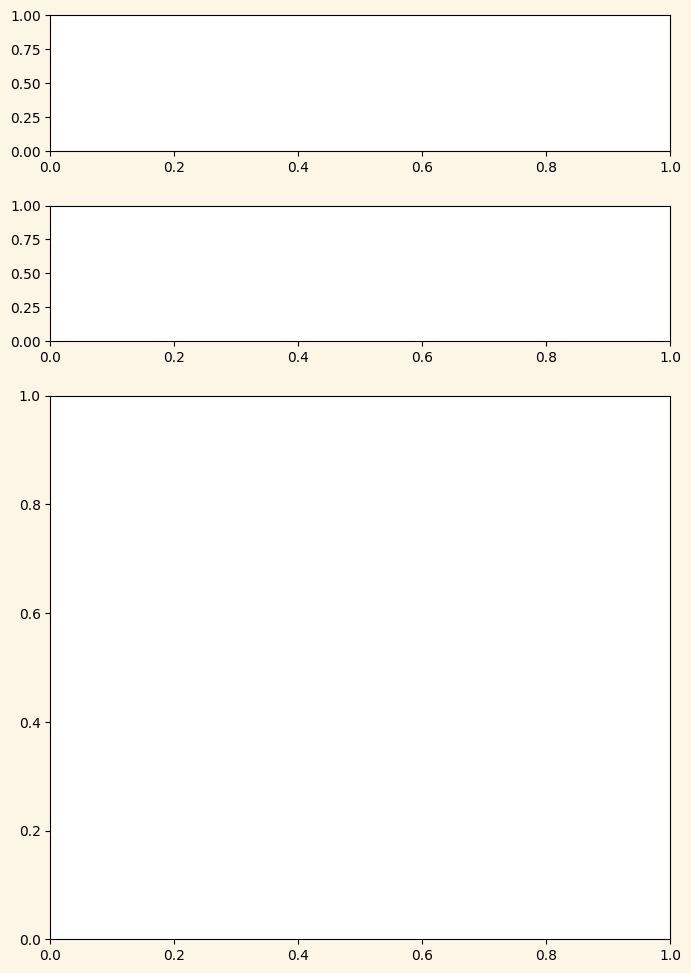

In [8]:
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
from typing import Tuple, Dict, Any

# This is a magic command that allows the plots to be displayed in the notebook
%matplotlib inline 




def setup_figure(args:Dict[str, Any])->Tuple[Figure, Dict[str, Axes]]:
    """
    Setup the figure and axes for the plot
    """
    fig = Figure(figsize=args['figsize'], facecolor=args['facecolor'])
    grid = GridSpec(3, 1, figure=fig, height_ratios=[2, args['gameflow_height'], args['figsize'][1] - 2 - args['gameflow_height']])
    axes = {
        'title': fig.add_subplot(grid[0]),
        'gameflow': fig.add_subplot(grid[1]),
        'xthreat': fig.add_subplot(grid[2])
    }
    return fig, axes

fig, axes = setup_figure(visualisation_arguments)
fig

Next, lets start by plotting a very basic series of bar charts on the `gameflow` axis


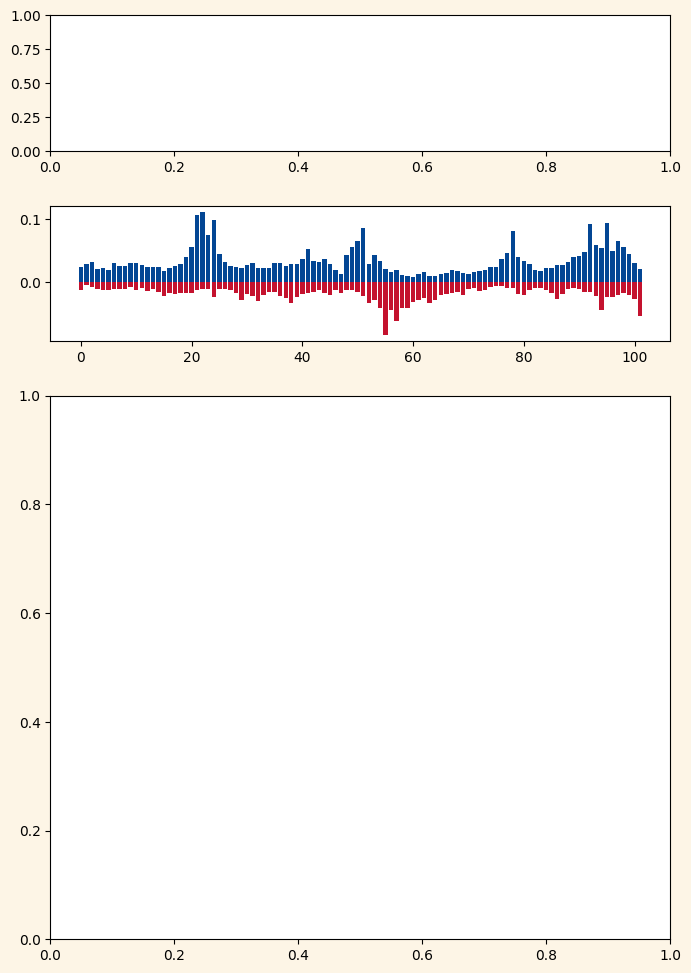

In [10]:
def basic_gameflow_chart(ax:Axes, data:pd.DataFrame, args:Dict[str, Any]):
    """
    Create a basic gameflow chart
    """

    data = data.copy()
    #simplify by converting the period and minute into a single time value
    data['time'] = data.apply(lambda x: x['minute'] if x['period'] == 1 else x['minute'] + data.loc[data['period']==1, 'minute'].max() - 45, axis=1)
    
    data = data.sort_values('time')

    #Away team goes on the bottom, so we need to invert the xthreat values
    data['xthreat']=data.apply(lambda x: x['xthreat'] if x['team']==args['home_team'] else -x['xthreat'], axis=1)
    
    home_data = data[data['team']==args['home_team']]
    away_data = data[data['team']==args['away_team']]

    #Plot the data
    ax.bar(home_data['time'], home_data['xthreat'], color=args['home_team_color'], label=args['home_team'])
    ax.bar(away_data['time'], away_data['xthreat'], color=args['away_team_color'], label=args['away_team'])

fig, axes= setup_figure(visualisation_arguments)
basic_gameflow_chart(axes['gameflow'], processed_data, visualisation_arguments)
fig

This is actually not bad, as far as things, go, but we can make it way better looking.

In order to improve the presentation, we will make the following changes
1. Hide the default x and y axes and make the background transparent and blend into the color of the overall plot
2. Create a nice looking timeline that separates the home and away rectangles, which will have minute indicators at regular interval.  Also, lets shade the extra time grey to clearly indicate it
3. Add little footballs to indicate when goals have been scored.

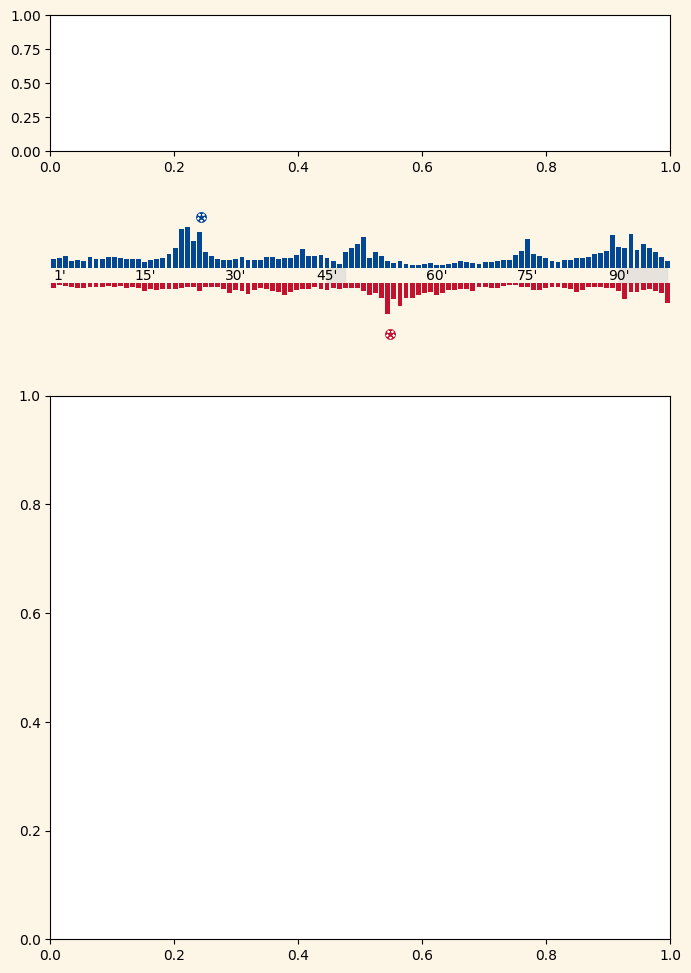

In [12]:
from mplsoccer.scatterutils import scatter_football
from matplotlib.patches import FancyBboxPatch, Rectangle, Wedge

fig, axes = setup_figure(visualisation_arguments)

def setup_central_timeline(ax, data, args):
    """
    This function will create the time line in the middle of the gameflow chart
    """
    first_period_labels = [1, 15, 30, 45]
    second_period_labels = [60, 75, 90]

    first_period_idx = [
        data.loc[(data['period'] == 1) & (data['minute'] == minute), 'time'].values[0]
        for minute in first_period_labels
    ]
    second_period_idx = [
        data.loc[(data['period'] == 2) & (data['minute'] == minute), 'time'].values[0]
        for minute in second_period_labels
    ]
    for idx, label in zip(first_period_idx + second_period_idx, first_period_labels + second_period_labels):
        ax.text(idx, 0, f"{label}'", ha='center', va='center', fontsize=10, color=args['text_color'])

    shade_extra_time(ax, data)

def shade_extra_time(ax:Axes, data:pd.DataFrame):
    """
    Shade the extra time on the time line
    """
    first_period__extra_time_range = (
        data.loc[(data['period'] == 1) & (data['minute'] == 45), 'time'].values[0],
        data.loc[data['period'] == 1, 'time'].max()
    )
    second_period__extra_time_range = (
        data.loc[(data['period'] == 2) & (data['minute'] == 90), 'time'].values[0],
        data.loc[data['period'] == 2, 'time'].max()
    )
                 

    ax.fill_betweenx([ -0.02, 0.02], *first_period__extra_time_range, color='lightgrey', alpha=0.5)
    ax.fill_betweenx([ -0.02, 0.02], *second_period__extra_time_range, color='lightgrey', alpha=0.5)

    
    

def setup_axis(ax:Axes, data:pd.DataFrame):
    """
    Set the axis dimention and turn off the default ticks and axis display

    """
    
    #set the x-axis limits and remove the default ticks
    ax.set_xlim(-0.5, data['time'].max()+0.5)
    max_xthreat = data['xthreat'].abs().max() + 0.08 # space for balls to indicate goals
    ax.set_ylim(min(max_xthreat, -0.18), max(max_xthreat, 0.18))
    ax.axis('off')
    
    
    

def draw_gameflow(ax:Axes, data:pd.DataFrame, args:Dict[str, Any]):
    """
    Draw the gameflow chart bars
    """
    
    home_data = data[data['team']==args['home_team']]
    away_data = data[data['team']==args['away_team']]

    #Plot the data
    ax.bar(home_data['time'], home_data['xthreat'], color=args['home_team_color'], label=args['home_team'], bottom=0.02, )
    ax.bar(away_data['time'], away_data['xthreat'], color=args['away_team_color'], label=args['away_team'], bottom=-0.02)



def place_goals(ax:Axes, data:pd.DataFrame, args:Dict[str, Any]):
    """
    Place the balls that represent on the gameflow chart.
    If more than one goal is scored at any minute, stack the balls diagonally 
    on top of each other
    """
    home_goals = data[(data['team']==args['home_team']) & (data['goals']>0)]
    away_goals = data[(data['team']==args['away_team']) & (data['goals']>0)]
    for i, r in home_goals.iterrows():
        n_goals = r['goals']
        for k in range(n_goals,0,-1):
            scatter_football(r['time']+k*0.3, 0.15+k*0.01, ax=ax, s=55, edgecolors=args['home_team_color'])
    for i, r in away_goals.iterrows():
        n_goals = r['goals']
        for k in range(n_goals,0,-1):
            scatter_football(r['time']+k*0.3, -0.15-k*0.01, ax=ax, s=55, edgecolors=args['away_team_color'])
    #scatter_football(away_goals['time'], [-0.135]*len(away_goals), ax=ax, s=55, edgecolors=args['away_team_color'])


def fancy_gameflow_chart(ax:Axes, data:pd.DataFrame, args:Dict[str, Any]):
    """
    Create a fancy gameflow chart
    """
    data = data.copy()
    #simplify by converting the period and minute into a single time value
    data['time'] = data.apply(lambda x: x['minute'] if x['period'] == 1 else x['minute'] + data.loc[data['period']==1, 'minute'].max() - 45, axis=1)
    data = data.sort_values('time')
    data['xthreat']=data.apply(lambda x: x['xthreat'] if x['team']==args['home_team'] else -x['xthreat'], axis=1)
    setup_axis(ax, data)
    setup_central_timeline(ax, data, args)
    draw_gameflow(ax, data, args)
    place_goals(ax, data, args)


fancy_gameflow_chart(axes['gameflow'], processed_data, visualisation_arguments)
fig